In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
import os
from shapely import wkt
from shapely.geometry import Point
from folium.plugins import HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Get the city from command-line arguments
#city = os.environ.get('CITY', 'Default City Name')
#base_path = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/"

# Sanitize the city name
#city_sanitized = city.split(",")[0].replace(" ", "_")
#city_path = f"{base_path}{city_sanitized}"  # Use the sanitized city name here

# Load data
#all_lts_df = pd.read_csv(f"{city_path}_all_lts.csv")
all_lts_df = pd.read_csv("/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Trento_all_lts.csv")
# Convert 'geometry' column from WKT strings to actual geometry objects
all_lts_df['geometry'] = all_lts_df['geometry'].apply(wkt.loads)

# Convert the DataFrame to a GeoDataFrame
all_lts = gpd.GeoDataFrame(all_lts_df, geometry='geometry')

# Set the CRS for the GeoDataFrame
all_lts.crs = "EPSG:32632"
all_lts_projected = all_lts.to_crs(epsg=4326)

#gdf_nodes = pd.read_csv(f"{city_path}_gdf_nodes.csv", index_col=0)
gdf_nodes = pd.read_csv("/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/Trento_gdf_nodes.csv", index_col=0)
gdf_nodes['geometry'] = gdf_nodes['geometry'].apply(wkt.loads)
# Convert the DataFrame to a GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(gdf_nodes, geometry='geometry')
gdf_nodes.crs = "EPSG:32632"
gdf_nodes_projected = gdf_nodes.to_crs(epsg=4326)

accidents_df = gpd.read_file("/Users/leonardo/Desktop/Tesi/LTSBikePlan/data/accidents_trento.geojson")
accidents_df = accidents_df.drop(columns=['id'], errors='ignore')
accidents_df.reset_index(inplace=True)
accidents_df.rename(columns={'index': 'id'}, inplace=True)
accidents_df.set_index('id', inplace=True)

base_path = "/Users/leonardo/Desktop/Tesi/LTSBikePlan/images"
city_name = "Trento"

# Create the path for the new folder
city_folder_path = os.path.join(base_path, city_name)

# Create the folder if it doesn't exist
if not os.path.exists(city_folder_path):
    os.makedirs(city_folder_path)





In [2]:
# Check if the 'geometry' column needs conversion
if isinstance(accidents_df.iloc[0]['geometry'], str):
    # Convert 'geometry' column from WKT strings to actual geometry objects
    accidents_df['geometry'] = accidents_df['geometry'].apply(wkt.loads)
elif isinstance(accidents_df.iloc[0]['geometry'], Point):
    # If already in Point format, no need to convert
    pass
else:
    raise ValueError("Unexpected geometry format in accidents_df")

# Convert the DataFrame to a GeoDataFrame for accidents
accidents_gdf = gpd.GeoDataFrame(accidents_df, geometry='geometry')

# Set the CRS for the GeoDataFrame to match the original data's CRS
accidents_gdf.crs = "EPSG:25832"

# Reproject the GeoDataFrame to WGS84 for mapping
accidents_gdf = accidents_gdf.to_crs(epsg=4326)

# Filter for the last 10 years (2013-2023)
#accidents_last_10_years = accidents_gdf[accidents_gdf['anno'].between(2013, 2023)]

# Filter for the last 5 years (2018-2023)
accidents_gdf = accidents_gdf[accidents_gdf['anno'].between(2018, 2023)].copy()

# Create a base map using Folium at a central location in your data
map_center = [accidents_gdf['geometry'].y.mean(), accidents_gdf['geometry'].x.mean()]
accident_map = folium.Map(location=map_center, zoom_start=12)

# Add each accident location as a marker on the map
for _, row in accidents_gdf.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7
    ).add_to(accident_map)

# Save the map to an HTML file
# Full path for the file
file_path = os.path.join(city_folder_path, 'accident_map.html')

# Assuming 'accident_map' is a Folium Map object
accident_map.save(file_path)

# Display the map in Jupyter Notebook (if you are using it)
accident_map


In [3]:
# Create a base map
heatmap_map = folium.Map(location=map_center, zoom_start=12)

# Extract coordinates for the heatmap
heat_data = [[point.xy[1][0], point.xy[0][0]] for point in accidents_gdf.geometry ]

# Create a HeatMap layer and add it to the base map
HeatMap(heat_data, 
        radius=13, 
        blur=15,
).add_to(heatmap_map)

# Save the map to an HTML file
# Full path for the file
file_path = os.path.join(city_folder_path, 'heatmap_map.html')

# Assuming 'accident_map' is a Folium Map object
heatmap_map.save(file_path)

heatmap_map


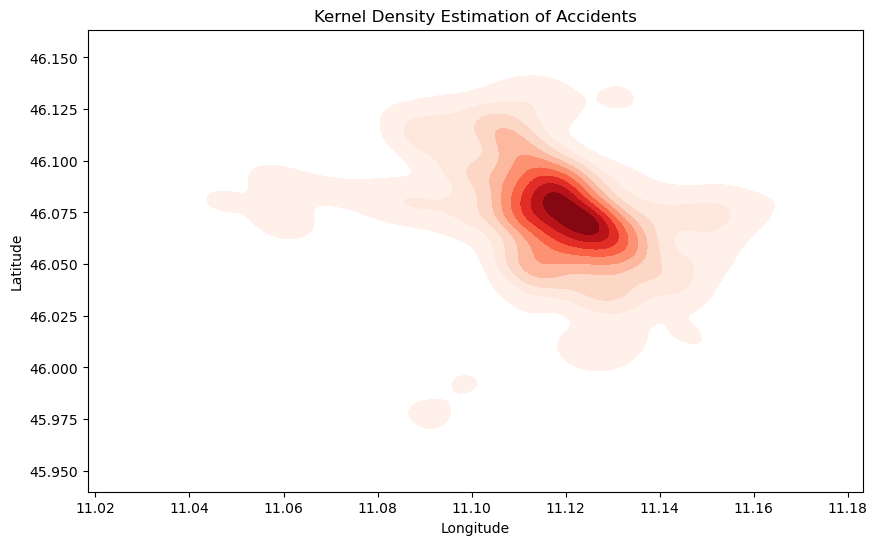

In [4]:
#KDE plot

x = accidents_gdf.geometry.x
y = accidents_gdf.geometry.y

# Create a KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x=x, y=y, shade=True, cmap="Reds")
plt.title('Kernel Density Estimation of Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [5]:
# Extract coordinates
x = accidents_gdf.geometry.x
y = accidents_gdf.geometry.y

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(x=x, y=y, shade=True, cmap="Reds")

x_min, x_max = accidents_gdf.geometry.x.min(), accidents_gdf.geometry.x.max()
y_min, y_max = accidents_gdf.geometry.y.min(), accidents_gdf.geometry.y.max()
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

plt.axis('off')

fig = ax.get_figure()
# Save the map to an HTML file
# Full path for the file
file_path = os.path.join(city_folder_path, 'kde_plot.png')

# Assuming 'accident_map' is a Folium Map object
fig.savefig(file_path, bbox_inches='tight', pad_inches=0, transparent=True)

plt.close(fig)


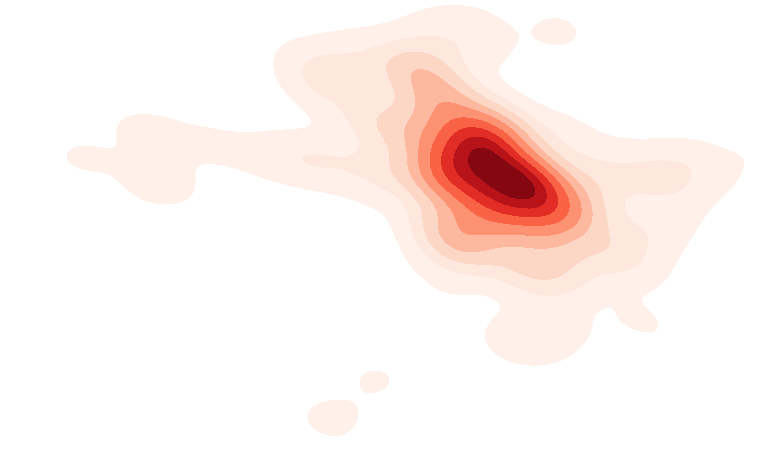

In [7]:
from folium import plugins

# Create a base map
map_center = [accidents_gdf.geometry.y.mean(), accidents_gdf.geometry.x.mean()]
kde_map = folium.Map(location=map_center, zoom_start=12)

bounds = [
    [accidents_gdf.geometry.y.min(), accidents_gdf.geometry.x.min()],
    [accidents_gdf.geometry.y.max(), accidents_gdf.geometry.x.max()]
]

# Create an ImageOverlay object
kde_image = folium.raster_layers.ImageOverlay(
    image='/Users/leonardo/Desktop/Tesi/LTSBikePlan/images/Trento/kde_plot.png',
    bounds=bounds,
    opacity=0.6  # adjust to your preference
)

kde_image.add_to(kde_map)

# Save the map to an HTML file
# Full path for the file
file_path = os.path.join(city_folder_path, 'kde_map.html')

# Assuming 'accident_map' is a Folium Map object
kde_map.save(file_path)

kde_map

In [8]:
from shapely.geometry import Point

all_lts = all_lts.to_crs(epsg=4326)

# Projection
accidents_gdf_projected = accidents_gdf.to_crs(epsg=32632)  
accidents_gdf_buffered = accidents_gdf_projected.copy()
accidents_gdf_buffered['geometry'] = accidents_gdf_projected.geometry.buffer(10)  # Buffer by 10 meters
accidents_gdf_buffered = accidents_gdf_buffered.to_crs(epsg=4326)

# Perform the spatial join again
accidents_near_edges = gpd.sjoin(accidents_gdf_buffered, all_lts, how='left', predicate='intersects')
accidents_near_edges = accidents_near_edges[accidents_near_edges['anno'].notna()]
accidents_near_edges['anno'] = accidents_near_edges['anno'].astype(int)

# Same analysis for nodes
gdf_nodes_projected['geometry'] = gdf_nodes_projected.apply(lambda row: Point(row['x'], row['y']), axis=1)
accidents_near_nodes = gpd.sjoin(accidents_gdf_buffered, gdf_nodes_projected, how='left', predicate='intersects')
accidents_near_nodes = accidents_near_nodes[accidents_near_nodes['anno'].notna()]
accidents_near_nodes['anno'] = accidents_near_nodes['anno'].astype(int)

#Filter data for the last 10 years
# accidents_near_edges = accidents_near_edges[(accidents_near_edges['anno'] >= 2013) & (accidents_near_edges['anno'] <= 2023)].copy()

In [9]:
accidents_near_edges['lanes_assumed'] = accidents_near_edges['lanes_assumed'].apply(lambda x: str(int(x)) if pd.notna(x) else x)
accidents_near_edges['maxspeed_assumed'] = accidents_near_edges['maxspeed_assumed'].apply(lambda x: str(int(x)) if pd.notna(x) else x)

# Fill NaN values in 'lanes' and 'maxspeed' with values from 'lanes_assumed'
accidents_near_edges['lanes'] = accidents_near_edges['lanes'].fillna(accidents_near_edges['lanes_assumed'])
accidents_near_edges['maxspeed'] = accidents_near_edges['maxspeed'].fillna(accidents_near_edges['maxspeed_assumed'])

# Check for NaN values again after filling
nan_lanes_after = accidents_near_edges['lanes'].isna().sum()
nan_maxspeed_after = accidents_near_edges['maxspeed'].isna().sum()

print(f"NaN values in 'lanes' after filling: {nan_lanes_after}")
print(f"NaN values in 'maxspeed' after filling: {nan_maxspeed_after}")



NaN values in 'lanes' after filling: 2198
NaN values in 'maxspeed' after filling: 2198


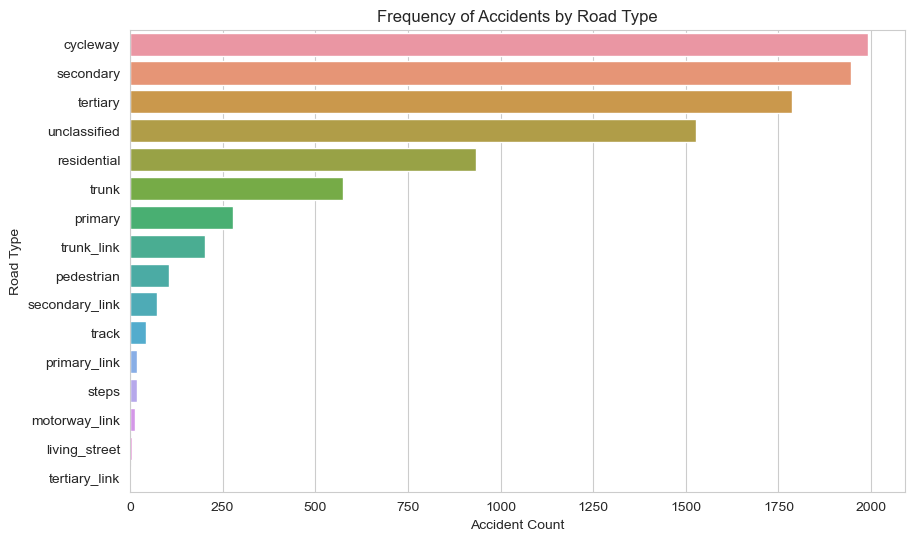

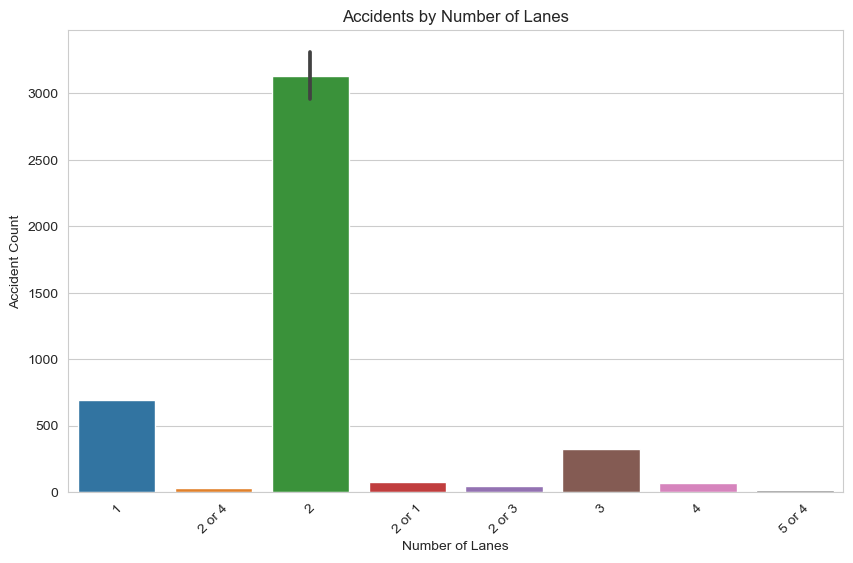

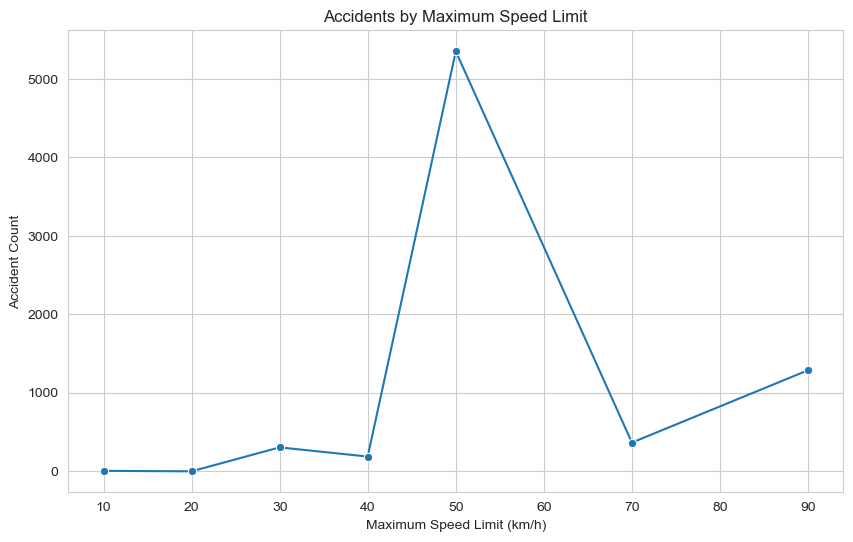

In [10]:
#Frequency of Accidents near different types of roads

# Count accidents by road type
accidents_by_road_type = accidents_near_edges.groupby('highway').size().reset_index(name='accident_count')
accidents_by_road_type.sort_values('accident_count', ascending=False, inplace=True)
#print(accidents_by_road_type)

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(data=accidents_by_road_type, x='accident_count', y='highway')
plt.xlabel('Accident Count')
plt.ylabel('Road Type')
plt.title('Frequency of Accidents by Road Type')
file_path = os.path.join(city_folder_path, 'frequencyaccidentsbyroads_plot.png')
plt.savefig(file_path)
plt.show()


# Correlation with number of lanes or maximum speed limits
accidents_near_edges['lanes'] = accidents_near_edges['lanes'].fillna(accidents_near_edges['lanes_assumed'])
accidents_near_edges['maxspeed'] = accidents_near_edges['maxspeed'].fillna(accidents_near_edges['maxspeed_assumed'])

# Aggregate by lanes and count accidents
accidents_by_lanes = accidents_near_edges.groupby('lanes').size().reset_index(name='accident_count')

def clean_lane_values(lane_value):
    lane_numbers = re.findall(r'\d+', lane_value)
    return ' or '.join(lane_numbers) if lane_numbers else lane_value

# Apply the cleaning function to the lanes column
accidents_by_lanes['lanes'] = accidents_by_lanes['lanes'].apply(clean_lane_values)

# Reorder lanes for plotting
accidents_by_lanes['lanes'] = pd.Categorical(accidents_by_lanes['lanes'], categories=sorted(set(accidents_by_lanes['lanes']), key=lambda x: float('inf') if x == '' else float(x.split(' or ')[0])))
accidents_by_lanes.sort_values('lanes', inplace=True)

# Bar plot for accidents by the number of lanes
plt.figure(figsize=(10, 6))
sns.barplot(data=accidents_by_lanes, x='lanes', y='accident_count')
plt.xlabel('Number of Lanes')
plt.ylabel('Accident Count')
plt.title('Accidents by Number of Lanes')
plt.xticks(rotation=45)
file_path = os.path.join(city_folder_path, 'accidentsbynumberlanes_plot.png')
plt.savefig(file_path)
plt.show()

# Aggregate by max_speed and count accidents
accidents_by_maxspeed = accidents_near_edges.groupby('maxspeed').size().reset_index(name='accident_count')

def clean_speed_limit(value):
    if 'IT:urban' in value:
        return 50
    else:
        speeds = [int(s) for s in re.findall(r'\d+', value)]
        return max(speeds) if speeds else 50  # Default to 50 if no numbers found

accidents_by_maxspeed['maxspeed'] = accidents_by_maxspeed['maxspeed'].apply(clean_speed_limit)
accidents_by_maxspeed = accidents_by_maxspeed.groupby('maxspeed').agg({'accident_count': 'sum'}).reset_index()

# Scatter plot for accidents by maximum speed limits
plt.figure(figsize=(10, 6))
sns.lineplot(data=accidents_by_maxspeed, x='maxspeed', y='accident_count', marker='o')
plt.xlabel('Maximum Speed Limit (km/h)')
plt.ylabel('Accident Count')
plt.title('Accidents by Maximum Speed Limit')
file_path = os.path.join(city_folder_path, 'accidentsbymaxspeed_plot.png')
plt.savefig(file_path)
plt.show()


In [11]:
def clean_and_average_lanes(lane):
    if pd.isna(lane):
        return np.nan
    # Extract numeric values from the string
    lane_values = re.findall(r'\d+', str(lane))
    # Convert extracted values to integers and calculate the mean
    lane_values = [int(val) for val in lane_values]
    return np.mean(lane_values) if lane_values else np.nan

# Apply the cleaning and averaging function to the 'lanes' column
accidents_near_edges['lanes'] = accidents_near_edges['lanes'].apply(clean_and_average_lanes)

# Check the transformed 'lanes' column
# print(accidents_near_edges['lanes'])

def clean_and_maximize_maxspeed(speed):
    if pd.isna(speed):
        return np.nan
    # Extract numeric values from the string
    speed_values = re.findall(r'\d+', str(speed))
    # Convert extracted values to integers and use the maximum
    speed_values = [int(val) for val in speed_values]
    return max(speed_values) if speed_values else np.nan

# Apply the cleaning and maximizing function to the 'maxspeed' column
accidents_near_edges['maxspeed'] = accidents_near_edges['maxspeed'].apply(clean_and_maximize_maxspeed)

# Check the transformed 'maxspeed' column
#print(accidents_near_edges['maxspeed'])

# Ensure 'lanes' and 'maxspeed' are numeric
accidents_near_edges['lanes'] = pd.to_numeric(accidents_near_edges['lanes'], errors='coerce')
accidents_near_edges['maxspeed'] = pd.to_numeric(accidents_near_edges['maxspeed'], errors='coerce')


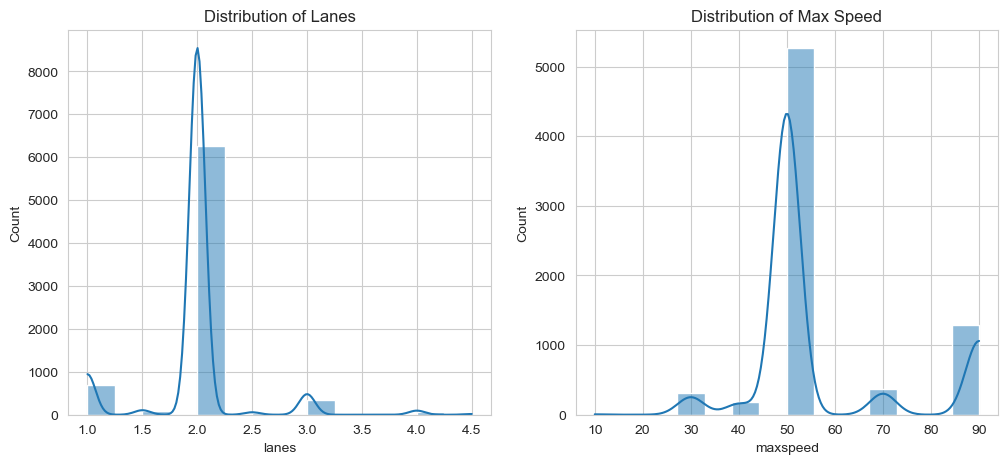

Shapiro test for lanes: ShapiroResult(statistic=0.551266074180603, pvalue=0.0)
Shapiro test for maxspeed: ShapiroResult(statistic=0.6583269834518433, pvalue=0.0)


/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# Histograms for visual inspection
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(accidents_near_edges['lanes'].dropna(), kde=True)
plt.title('Distribution of Lanes')
plt.subplot(1, 2, 2)
sns.histplot(accidents_near_edges['maxspeed'].dropna(), kde=True)
plt.title('Distribution of Max Speed')
file_path = os.path.join(city_folder_path, 'lanes_speed_distribution_plot.png')
plt.savefig(file_path)
plt.show()

# Shapiro-Wilk normality test
shapiro_lanes = shapiro(accidents_near_edges['lanes'].dropna())
shapiro_maxspeed = shapiro(accidents_near_edges['maxspeed'].dropna())

print(f"Shapiro test for lanes: {shapiro_lanes}")
print(f"Shapiro test for maxspeed: {shapiro_maxspeed}")

In [13]:
from scipy.stats import  spearmanr

# Drop NaN values for correlation analysis
accidents_for_correlation = accidents_near_edges.dropna(subset=['lanes', 'maxspeed'])

# Pearson Correlation
# pearson_corr, pearson_pval = pearsonr(accidents_for_correlation['lanes'], accidents_for_correlation['maxspeed'])
# print(f"Pearson Correlation: {pearson_corr}, P-value: {pearson_pval}")

# Spearman Correlation
spearman_corr, spearman_pval = spearmanr(accidents_for_correlation['lanes'], accidents_for_correlation['maxspeed'])
print(f"Spearman Correlation: {spearman_corr}, P-value: {spearman_pval}")


Spearman Correlation: 0.003993752754320861, P-value: 0.7307869688541309


In [15]:
# Post-hoc Analysis

# 1) Subgroup Analysis

road_types = accidents_near_edges['highway'].unique()

for road_type in road_types:
    subset = accidents_near_edges[accidents_near_edges['highway'] == road_type]
    spearman_corr, spearman_pval = spearmanr(subset['lanes'], subset['maxspeed'], nan_policy='omit')
    print(f"Road Type: {road_type}, Spearman Correlation: {spearman_corr}, P-value: {spearman_pval}")


# Road types that had nan correlations
road_types_nan_corr = ['cycleway', 'primary_link', 'tertiary_link', 'living_street', 'motorway']

for road_type in road_types_nan_corr:
    print(f"Road Type: {road_type}")
    subset = accidents_near_edges[accidents_near_edges['highway'] == road_type]
    
    # Investigating 'lanes'
    print("Lanes Distribution:")
    print(subset['lanes'].value_counts(dropna=False))

    # Investigating 'maxspeed'
    print("Maxspeed Distribution:")
    print(subset['maxspeed'].value_counts(dropna=False))

    print("\n")

# Road types for the variance check
road_types = accidents_near_edges['highway'].unique()

for road_type in road_types:
    subset = accidents_near_edges[accidents_near_edges['highway'] == road_type]

    # Calculating variance
    lanes_variance = subset['lanes'].var()
    maxspeed_variance = subset['maxspeed'].var()

    # Check if variance is close to zero
    if lanes_variance < 0.01 or maxspeed_variance < 0.01:
        print(f"Skipping correlation test for road type {road_type} due to low variance in lanes or maxspeed.")
    else:
        # Perform the correlation test
        spearman_corr, spearman_pval = spearmanr(subset['lanes'], subset['maxspeed'], nan_policy='omit')
        print(f"Road Type: {road_type}, Spearman Correlation: {spearman_corr}, P-value: {spearman_pval}")


Road Type: cycleway, Spearman Correlation: nan, P-value: nan
Road Type: unclassified, Spearman Correlation: 0.035075133380180715, P-value: 0.1748344734016118
Road Type: secondary, Spearman Correlation: -0.2902896800088537, P-value: 4.4690613973717905e-38
Road Type: residential, Spearman Correlation: -0.01631352511550142, P-value: 0.6209932749307007
Road Type: trunk, Spearman Correlation: -0.2698871696704252, P-value: 4.702161885475832e-11
Road Type: nan, Spearman Correlation: nan, P-value: nan
Road Type: tertiary, Spearman Correlation: -0.0011099131603956737, P-value: 0.962614193585655
Road Type: secondary_link, Spearman Correlation: nan, P-value: nan
Road Type: pedestrian, Spearman Correlation: 0.39840953644479793, P-value: 2.33963562114424e-05
Road Type: trunk_link, Spearman Correlation: -0.14010466837547172, P-value: 0.048989145665594716
Road Type: primary, Spearman Correlation: -0.06675965956865647, P-value: 0.2672884437515464
Road Type: track, Spearman Correlation: 0.0, P-value: 1

/Users/leonardo/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


For road types like 'unclassified', 'secondary', 'trunk' and others, there are significant Spearman correlation coefficients, suggesting a meaningful statistical relationship between the number of lanes and max speed on roads with accidents. 

For road types like 'cycleway', 'primary_link', 'tertiary_link', 'living_street', and 'motorway', either the correlation results are nan, or the test was skipped due to low variance. This typically indicates that there isn't enough variability in either the number of lanes or max speed data for those road types in your dataset, or that all values are constant. 
For example: in 'cycleway', both lanes and max speed are NaN for all entries, leading to undefined correlation, in 'primary_link', all max speed values are 50, providing no variability.
Similar situations are observed for 'tertiary_link', 'living_street', and 'motorway'.

**Interpretation and Next Steps**

The findings here suggest a relationship between the number of lanes and the maximum speed limit that varies by road type. For example, the negative correlation on 'secondary' roads might indicate complex traffic conditions where additional lanes do not necessarily lead to higher speed limits, potentially due to factors like traffic density or road design. The lack of variability in these categories means that correlation analysis isn't informative for these road types. This could be due to the nature of these roads (e.g., 'cycleways' typically don't vary in the number of lanes or speed limits) or data limitations.

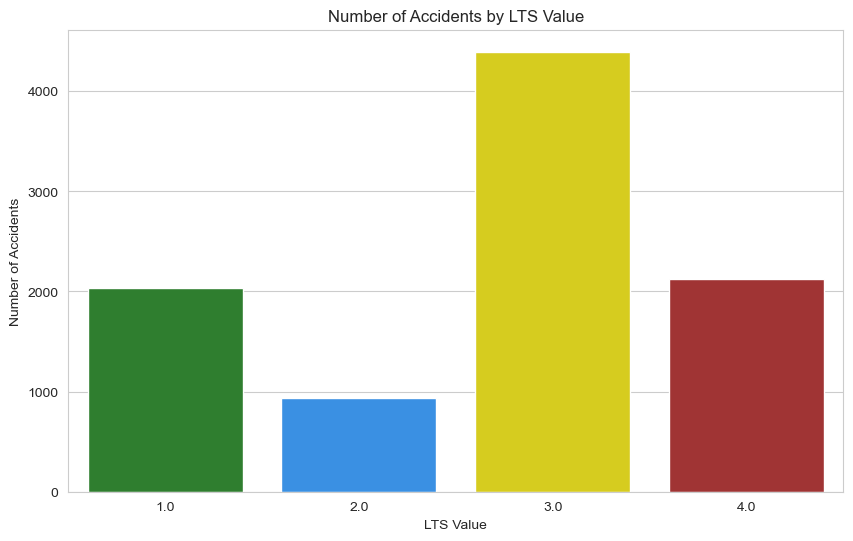

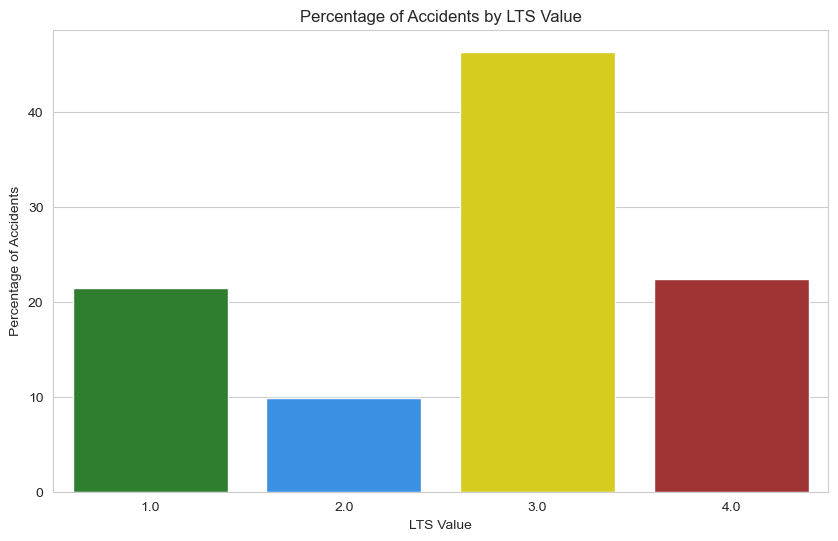

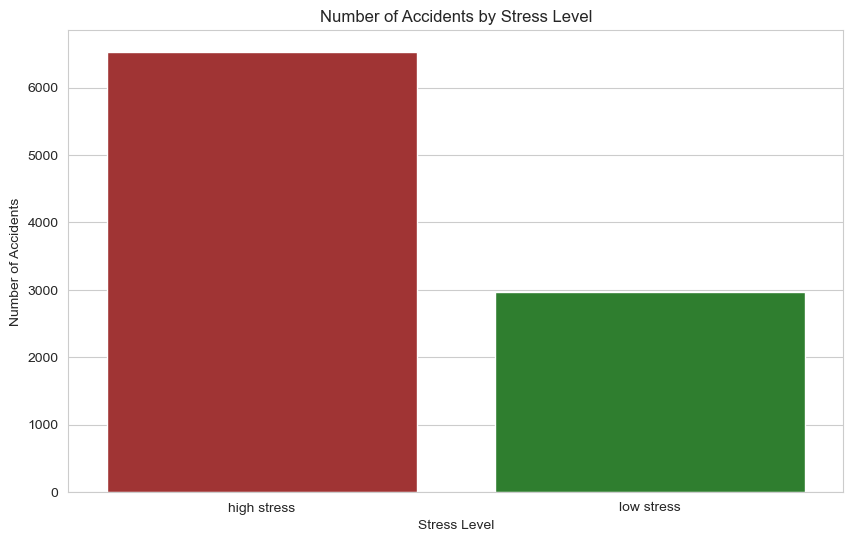

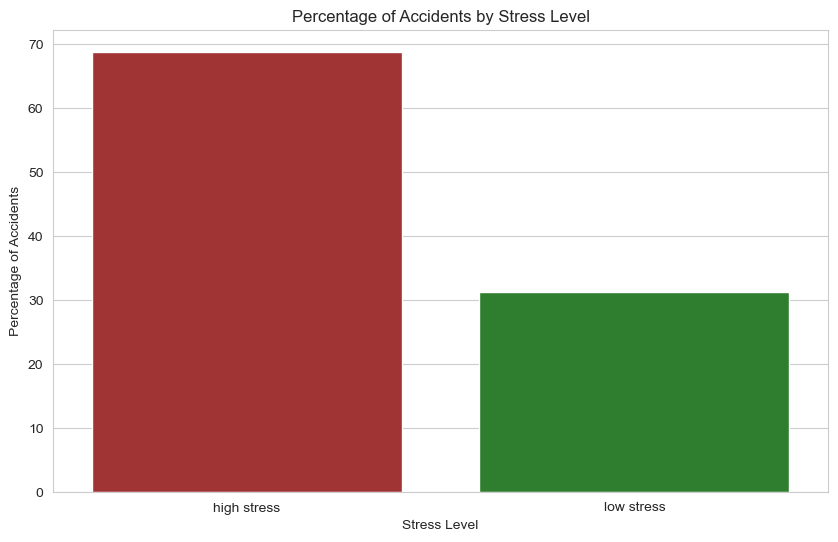

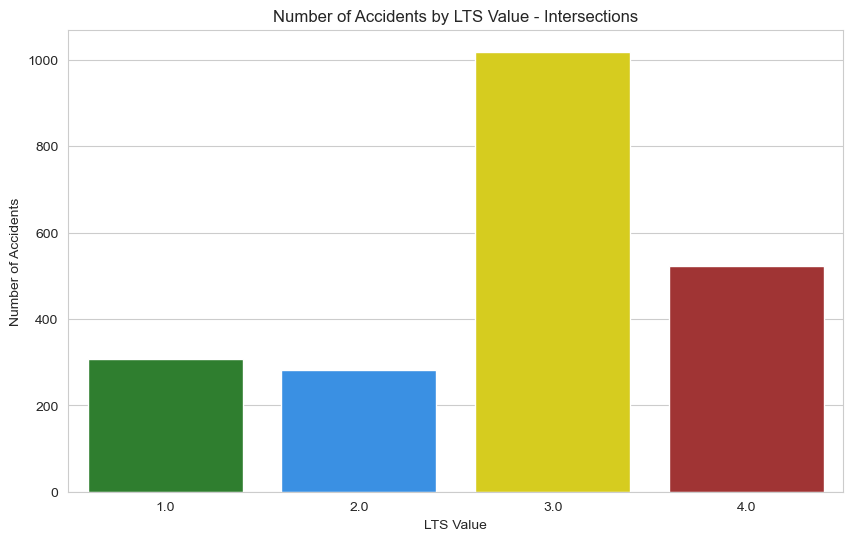

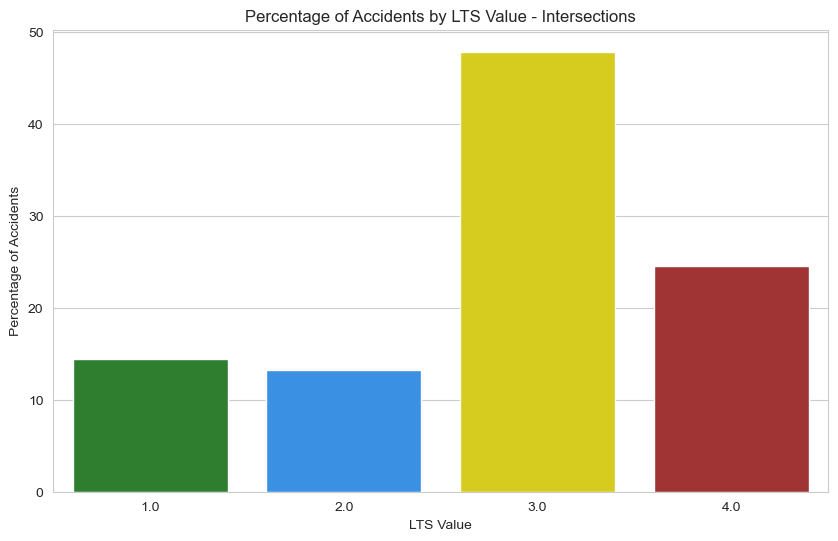

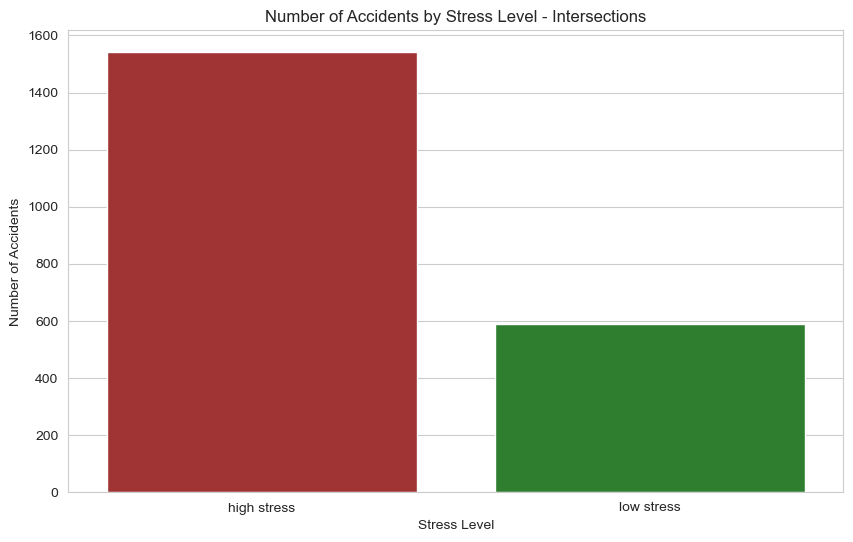

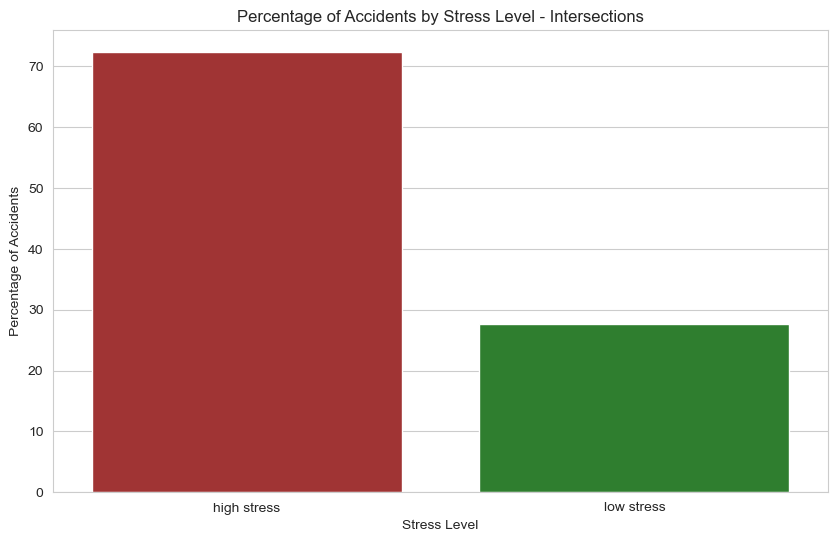

In [17]:
# Accident Frequency Near Roads with Different LTS Values

accidents_filtered = accidents_near_edges[(accidents_near_edges['lts'] != 0) & (accidents_near_edges['lts'].notna())].copy()
accidents_by_lts = accidents_filtered.groupby('lts').size().reset_index(name='accident_count')
accidents_by_lts.sort_values('accident_count', ascending=False, inplace=True)
total_accidents = accidents_by_lts['accident_count'].sum()
accidents_by_lts['percentage'] = (accidents_by_lts['accident_count'] / total_accidents) * 100

# Plotting LTS values
custom_palette = ["forestgreen", "dodgerblue", "#f4e800", "firebrick"]  
plt.figure(figsize=(10, 6))
sns.barplot(x='lts', y='accident_count', data=accidents_by_lts, palette=custom_palette)
plt.title('Number of Accidents by LTS Value')
plt.xlabel('LTS Value')
plt.ylabel('Number of Accidents')
file_path = os.path.join(city_folder_path, 'accidents_lts_plot.png')
plt.savefig(file_path)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='lts', y='percentage', data=accidents_by_lts, palette=custom_palette)
plt.title('Percentage of Accidents by LTS Value')
plt.xlabel('LTS Value')
plt.ylabel('Percentage of Accidents')
file_path = os.path.join(city_folder_path, 'perc_accidents_lts_plot.png')
plt.savefig(file_path)
plt.show()

# Creating stress level categories
accidents_filtered['stress_level'] = accidents_filtered['lts'].apply(lambda x: 'low stress' if x in [1, 2] else ('high stress' if x in [3, 4] else 'undefined'))
accidents_stress_level = accidents_filtered[accidents_filtered['stress_level'] != 'undefined']
accidents_by_stress_level = accidents_stress_level.groupby('stress_level').size().reset_index(name='accident_count')
total_accidents_stress_level = accidents_by_stress_level['accident_count'].sum()
accidents_by_stress_level['percentage'] = (accidents_by_stress_level['accident_count'] / total_accidents_stress_level) * 100

custom_palette_s = ['firebrick', 'forestgreen']  

# Plotting Stress Levels
plt.figure(figsize=(10, 6))
sns.barplot(x='stress_level', y='accident_count', data=accidents_by_stress_level, palette=custom_palette_s)
plt.title('Number of Accidents by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Number of Accidents')
file_path = os.path.join(city_folder_path, 'accidents_stress_level_plot.png')
plt.savefig(file_path)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='stress_level', y='percentage', data=accidents_by_stress_level, palette=custom_palette_s)
plt.title('Percentage of Accidents by Stress Level')
plt.xlabel('Stress Level')
plt.ylabel('Percentage of Accidents')
file_path = os.path.join(city_folder_path, 'perc_accidents_stress_level_plot.png')
plt.savefig(file_path)
plt.show()


#Nodes

accidents_filtered_n = accidents_near_nodes[(accidents_near_nodes['lts'] != 0) & (accidents_near_nodes['lts'].notna())].copy()
accidents_by_lts_n = accidents_filtered_n.groupby('lts').size().reset_index(name='accident_count')
accidents_by_lts_n.sort_values('accident_count', ascending=False, inplace=True)
total_accidents_n = accidents_by_lts_n['accident_count'].sum()
accidents_by_lts_n['percentage'] = (accidents_by_lts_n['accident_count'] / total_accidents_n) * 100

# Plotting LTS values
plt.figure(figsize=(10, 6))
sns.barplot(x='lts', y='accident_count', data=accidents_by_lts_n, palette=custom_palette)
plt.title('Number of Accidents by LTS Value - Intersections')
plt.xlabel('LTS Value')
plt.ylabel('Number of Accidents')
file_path = os.path.join(city_folder_path, 'accidents_lts_intersection_plot.png')
plt.savefig(file_path)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='lts', y='percentage', data=accidents_by_lts_n, palette=custom_palette)
plt.title('Percentage of Accidents by LTS Value - Intersections')
plt.xlabel('LTS Value')
plt.ylabel('Percentage of Accidents')
file_path = os.path.join(city_folder_path, 'perc_accidents_lts_intersection_plot.png')
plt.savefig(file_path)
plt.show()

# Creating stress level categories
accidents_filtered_n['stress_level'] = accidents_filtered_n['lts'].apply(lambda x: 'low stress' if x in [1, 2] else ('high stress' if x in [3, 4] else 'undefined'))
accidents_stress_level_n = accidents_filtered_n[accidents_filtered_n['stress_level'] != 'undefined']
accidents_by_stress_level_n = accidents_stress_level_n.groupby('stress_level').size().reset_index(name='accident_count')
total_accidents_stress_level_n = accidents_by_stress_level_n['accident_count'].sum()
accidents_by_stress_level_n['percentage'] = (accidents_by_stress_level_n['accident_count'] / total_accidents_stress_level_n) * 100

# Plotting Stress Levels
plt.figure(figsize=(10, 6))
sns.barplot(x='stress_level', y='accident_count', data=accidents_by_stress_level_n, palette=custom_palette_s)
plt.title('Number of Accidents by Stress Level - Intersections')
plt.xlabel('Stress Level')
plt.ylabel('Number of Accidents')
file_path = os.path.join(city_folder_path, 'accidents_stress_level_intersection_plot.png')
plt.savefig(file_path)
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='stress_level', y='percentage', data=accidents_by_stress_level_n, palette=custom_palette_s)
plt.title('Percentage of Accidents by Stress Level - Intersections')
plt.xlabel('Stress Level')
plt.ylabel('Percentage of Accidents')
file_path = os.path.join(city_folder_path, 'perc_accidents_stress_level_intersection_plot.png')
plt.savefig(file_path)
plt.show()



In [18]:
# Test if the difference is significant or not in both scenarios

#Goodness-of-Fit Chi-Square test => test compares the observed counts to expected counts under a null hypothesis that all categories have the same frequency.
contingency_table = accidents_by_lts.pivot_table(index='lts', values='accident_count', aggfunc='sum')

from scipy.stats import chisquare

# Using the Goodness-of-Fit Chi-Square test
chi2, p = chisquare(contingency_table['accident_count'])

# Interpreting the results
print("Chi-Square value:", chi2)
print(f"P-value: {p:.10f}")

if p < 0.05:
    # Pairwise comparisons (example with a simple loop, consider Bonferroni correction)
    for i in range(len(contingency_table)):
        for j in range(i+1, len(contingency_table)):
            # Extract only the accident count values for the comparison
            obs = [contingency_table['accident_count'].iloc[i], contingency_table['accident_count'].iloc[j]]
            chi2, p_pairwise = chisquare(obs)
            if p_pairwise < 0.05:  # Adjust this threshold for multiple tests
                print(f"Significant difference between LTS {contingency_table.index[i]} and LTS {contingency_table.index[j]} (p={p_pairwise:.10f})")

Chi-Square value: 2672.0362563237773
P-value: 0.0000000000
Significant difference between LTS 1.0 and LTS 2.0 (p=0.0000000000)
Significant difference between LTS 1.0 and LTS 3.0 (p=0.0000000000)
Significant difference between LTS 2.0 and LTS 3.0 (p=0.0000000000)
Significant difference between LTS 2.0 and LTS 4.0 (p=0.0000000000)
Significant difference between LTS 3.0 and LTS 4.0 (p=0.0000000000)


In [19]:
# Test if the difference is significant or not in both scenarios - intersections

#Goodness-of-Fit Chi-Square test => test compares the observed counts to expected counts under a null hypothesis that all categories have the same frequency.
contingency_table = accidents_by_lts_n.pivot_table(index='lts', values='accident_count', aggfunc='sum')

from scipy.stats import chisquare

# Using the Goodness-of-Fit Chi-Square test
chi2, p = chisquare(contingency_table['accident_count'])

# Interpreting the results
print("Chi-Square value:", chi2)
print(f"P-value: {p:.10f}")

if p < 0.05:
    # Pairwise comparisons (example with a simple loop, consider Bonferroni correction)
    for i in range(len(contingency_table)):
        for j in range(i+1, len(contingency_table)):
            # Extract only the accident count values for the comparison
            obs = [contingency_table['accident_count'].iloc[i], contingency_table['accident_count'].iloc[j]]
            chi2, p_pairwise = chisquare(obs)
            if p_pairwise < 0.05:  # Adjust this threshold for multiple tests
                print(f"Significant difference between LTS {contingency_table.index[i]} and LTS {contingency_table.index[j]} (p={p_pairwise:.10f})")

Chi-Square value: 656.7672454246833
P-value: 0.0000000000
Significant difference between LTS 1.0 and LTS 3.0 (p=0.0000000000)
Significant difference between LTS 1.0 and LTS 4.0 (p=0.0000000000)
Significant difference between LTS 2.0 and LTS 3.0 (p=0.0000000000)
Significant difference between LTS 2.0 and LTS 4.0 (p=0.0000000000)
Significant difference between LTS 3.0 and LTS 4.0 (p=0.0000000000)


In [20]:
# Preparing a contingency table for the Chi-Square test
contingency_table = accidents_by_stress_level.pivot_table(index='stress_level', values='accident_count', aggfunc='sum')

# Using the Goodness-of-Fit Chi-Square test
chi2, p = chisquare(contingency_table['accident_count'])

# Interpreting the results
print("Chi-Square value:", chi2)
print(f"P-value: {p:.10f}")

if p < 0.05:
    # Pairwise comparisons (example with a simple loop, consider Bonferroni correction)
    for i in range(len(contingency_table)):
        for j in range(i+1, len(contingency_table)):
            # Extract only the accident count values for the comparison
            obs = [contingency_table['accident_count'].iloc[i], contingency_table['accident_count'].iloc[j]]
            chi2, p_pairwise = chisquare(obs)
            if p_pairwise < 0.05:  # Adjust this threshold for multiple tests
                print(f"Significant difference between LTS {contingency_table.index[i]} and LTS {contingency_table.index[j]} (p={p_pairwise:.10f})")

Chi-Square value: 1332.7504215851602
P-value: 0.0000000000
Significant difference between LTS high stress and LTS low stress (p=0.0000000000)


In [21]:
# Preparing a contingency table for the Chi-Square test
contingency_table = accidents_by_stress_level_n.pivot_table(index='stress_level', values='accident_count', aggfunc='sum')

# Using the Goodness-of-Fit Chi-Square test
chi2, p = chisquare(contingency_table['accident_count'])

# Interpreting the results
print("Chi-Square value:", chi2)
print(f"P-value: {p:.10f}")

if p < 0.05:
    # Pairwise comparisons (example with a simple loop, consider Bonferroni correction)
    for i in range(len(contingency_table)):
        for j in range(i+1, len(contingency_table)):
            # Extract only the accident count values for the comparison
            obs = [contingency_table['accident_count'].iloc[i], contingency_table['accident_count'].iloc[j]]
            chi2, p_pairwise = chisquare(obs)
            if p_pairwise < 0.05:  # Adjust this threshold for multiple tests
                print(f"Significant difference between LTS {contingency_table.index[i]} and LTS {contingency_table.index[j]} (p={p_pairwise:.10f})")

Chi-Square value: 424.40215861098073
P-value: 0.0000000000
Significant difference between LTS high stress and LTS low stress (p=0.0000000000)


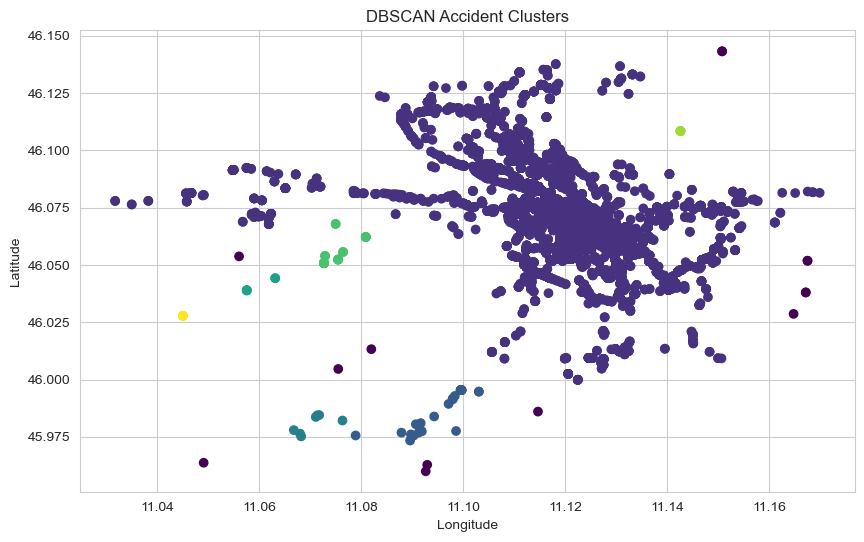

In [22]:
from sklearn.cluster import DBSCAN
coordinates = accidents_near_edges[['x_gps', 'y_gps']]

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.01, min_samples=4)  
dbscan_clusters = dbscan.fit_predict(coordinates)
accidents_near_edges['dbscan_cluster'] = dbscan_clusters

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(accidents_near_edges['x_gps'], accidents_near_edges['y_gps'], c=accidents_near_edges['dbscan_cluster'], cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Accident Clusters')
file_path = os.path.join(city_folder_path, 'DBSCAN_accident_clusters_plot.png')
plt.savefig(file_path)
plt.show()

In [23]:
# Counting the number of accidents in each cluster
cluster_counts = accidents_near_edges['dbscan_cluster'].value_counts().sort_index()
print("Cluster Counts:\n", cluster_counts)

# Determine the number of clusters (excluding outliers marked as -1)
num_clusters = len(cluster_counts) - (1 if -1 in cluster_counts else 0)
print("\nNumber of Clusters (excluding outliers):", num_clusters)

# Convert to a GeoDataFrame
gdf = gpd.GeoDataFrame(accidents_near_edges, geometry=gpd.points_from_xy(accidents_near_edges.x_gps, accidents_near_edges.y_gps))

# Calculate centroids of each cluster
for cluster_num in range(num_clusters):
    cluster_points = gdf[gdf['dbscan_cluster'] == cluster_num]
    centroid = cluster_points.geometry.unary_union.centroid
    print(f"Centroid of Cluster {cluster_num}: {centroid}")

Cluster Counts:
 -1      14
 0    9626
 1      25
 2       7
 3       6
 4      22
 5       5
 6       4
Name: dbscan_cluster, dtype: int64

Number of Clusters (excluding outliers): 7
Centroid of Cluster 0: POINT (11.118002876267965 46.073993006212866)
Centroid of Cluster 1: POINT (11.093806259339098 45.983681237450156)
Centroid of Cluster 2: POINT (11.070510389482383 45.98065575339628)
Centroid of Cluster 3: POINT (11.060336543750001 46.04162798315)
Centroid of Cluster 4: POINT (11.075559457507984 46.0571852409493)
Centroid of Cluster 5: POINT (11.1426256606 46.1084526106)
Centroid of Cluster 6: POINT (11.0450222936 46.0278495924)


In [25]:
# import the lts folium level map from other file
# add over this the incidents of the last 10 years in the first map
# add over this the incidents of the last 5 years in the first map
import folium
import h3
import os
from shapely import wkt
from shapely.geometry import box, Polygon
from folium.plugins import Geocoder
from folium import FeatureGroup, LayerControl

color_palette = ["forestgreen", "dodgerblue", "#f4e800", "firebrick", "#000000", "purple"]
lts_classes = [1, 2, 3, 4, "undefined", "not cyclable"]
colors = dict(zip(lts_classes, color_palette))

mean_latitude = all_lts_projected.geometry.apply(lambda geom: geom.centroid.y).mean()
mean_longitude = all_lts_projected.geometry.apply(lambda geom: geom.centroid.x).mean()

map_osm = folium.Map(location=[mean_latitude, mean_longitude], zoom_start=11.5)

geocoder = Geocoder(
    position='topleft',
    control=True,
    collapsed=True,
    auto_type=True,
    placeholder='Search for a location...',
    max_zoom=15,
    hide_marker=True
).add_to(map_osm)

feature_groups = {}

for lts_class, color in colors.items():
    if isinstance(lts_class, str):  # For "Undefined" and "Not cyclable"
        name = lts_class
    else:
        name = f"LTS {lts_class}"
    toggle_switch_html = f'''
    <div class="toggle-switch active" onclick="toggleSwitch(this)" style="background-color: {color};"></div>
    <span>{name}</span>
    '''
    is_visible = False if lts_class == "undefined" else True
    feature_group = FeatureGroup(name=toggle_switch_html, show=is_visible)
    feature_groups[lts_class] = feature_group
    feature_group.add_to(map_osm)

# Function to generate hexagons
def get_hexagons_for_bounds(bounds, resolution):
    bounding_polygon = box(*bounds)
    center = bounding_polygon.centroid
    hex_center = h3.geo_to_h3(center.y, center.x, resolution)
    hexagons = h3.k_ring(hex_center, 100)
    hexagons = [hexagon for hexagon in hexagons if h3.h3_to_geo_boundary(hexagon, geo_json=True)]
    return hexagons

hexagons = get_hexagons_for_bounds(all_lts_projected.total_bounds, 9)
bounding_polygon = box(*all_lts_projected.total_bounds)

# Filter hexagons to keep only those intersecting with the bounding polygon
hexagons = [h for h in hexagons if Polygon(h3.h3_to_geo_boundary(h, geo_json=True)).intersects(bounding_polygon)]

hex_gdf = gpd.GeoDataFrame({'hex_id': hexagons, 
                            'geometry': [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]}, 
                           crs="EPSG:4326")

# Function to find prevalent LTS within each hexagon
def get_prevalent_lts(hex_geometry):
    # Find streets within the hexagon
    streets_within_hex = all_lts_projected[all_lts_projected.intersects(hex_geometry)]
    if streets_within_hex.empty:
        return np.nan
    # Return prevalent LTS
    return streets_within_hex['lts'].value_counts().idxmax()

hex_gdf['lts'] = hex_gdf['geometry'].apply(get_prevalent_lts)

for _, row in hex_gdf.iterrows():
    if pd.isna(row['lts']):
        lts_class = "undefined"
        color = colors[lts_class]
    elif row['lts'] not in feature_groups:
        lts_class = "undefined"
        color = colors[lts_class]
    else:
        streets_within_hex = all_lts_projected[all_lts_projected.intersects(row['geometry'])]
        names = streets_within_hex['name'].fillna("").str.lower()
        if any(names.str.contains(keyword).any() for keyword in ["tangenziale", "superstrada", "strada statale", "autostrada", "strada a scorrimento veloce"]) and not names.str.contains("bici|cicla|ciclo").any():
            lts_class = "not cyclable"
            color = colors[lts_class]
        else:
            lts_class = row['lts']
            color = colors[lts_class]
    
    folium.GeoJson(
        row['geometry'], 
        style_function=lambda _, color=color: {'color': "#000000", 'fillColor': color, 'fillOpacity': 0.7, 'weight': 2}
    ).add_to(feature_groups[lts_class])

LayerControl(position='topright').add_to(map_osm)

def add_accidents_to_map(accidents, map_object):
    for _, row in accidents.iterrows():
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=2,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.7
        ).add_to(map_object)

# def add_accidents_to_map_5(accidents, map_object):
#     for _, row in accidents.iterrows():
#         folium.CircleMarker(
#             location=[row.geometry.y, row.geometry.x],
#             radius=2,
#             color='red',
#             fill=True,
#             fill_color='darkred',
#             fill_opacity=0.7
#         ).add_to(map_object)

# Create map with accidents from the last 10 years
# add_accidents_to_map(accidents_last_10_years, map_osm_10_years)
add_accidents_to_map(accidents_gdf, map_osm)

map_html = open("custom_map.html", "r").read()
map_osm.get_root().html.add_child(folium.Element(map_html))

file_path = os.path.join(city_folder_path, 'choropleth_lts_accidents_map.html')

# Assuming 'accident_map' is a Folium Map object
map_osm.save(file_path)

map_osm

